# 3. Customer Segmentation with K-Means Clustering

### Project Objective
This notebook moves beyond the rule-based RFM segmentation from the previous step and applies an unsupervised machine learning approach—**K-Means Clustering**—to identify natural groupings in our customer data. The goal is to see if a data-driven approach can validate or enhance our initial RFM segments.

### What is K-Means Clustering?
K-Means is an algorithm that partitions data into 'K' distinct, non-overlapping clusters. It groups data points based on their proximity to a cluster's centroid, aiming to minimize the distance within clusters and maximize the distance between clusters. It is particularly effective for identifying customer personas based on behavioral data.

### Objectives of this Notebook
1.  **Prepare Data for Clustering:** Scale the RFM features to ensure equal contribution to the model.
2.  **Determine Optimal Cluster Number (K):** Use statistical methods (Elbow Method and Silhouette Analysis) to find the most appropriate number of clusters.
3.  **Build and Analyze Clusters:** Train the K-Means model and profile the resulting segments to understand their characteristics.
4.  **Refine the Analysis:** Identify and handle outliers to create a more meaningful segmentation of the core B2C customer base.
5.  **Visualize and Save Segments:** Present the final, actionable segments and save the results for the next phase of the project (churn prediction).

In [2]:
# Cell 1: Imports and Data Loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Load the pre-processed, customer-level data
customer_df = pd.read_csv('../data/processed/rfm_customer_data.csv')
print("Successfully loaded rfm_customer_data.csv")
print(f"Data has {customer_df.shape[0]} customers and {customer_df.shape[1]} features.")

# For this analysis, we'll set CustomerID as the index.
# This helps in identifying customers but won't be used in the clustering itself.
customer_df_indexed = customer_df.set_index('CustomerID')

# Select the features for clustering
features = ['Recency', 'Frequency', 'Monetary']
cluster_df = customer_df_indexed[features]

print("\nFeatures selected for clustering:")
print(cluster_df.head())

Successfully loaded rfm_customer_data.csv
Data has 4338 customers and 13 features.

Features selected for clustering:
            Recency  Frequency  Monetary
CustomerID                              
12346.0         326          1  77183.60
12347.0           2          7   4310.00
12348.0          75          4   1797.24
12349.0          19          1   1757.55
12350.0         310          1    334.40


In [3]:
# Cell 2: Feature Scaling
# Scaling is critical for distance-based algorithms like K-Means.
scaler = StandardScaler()
scaled_features = scaler.fit_transform(cluster_df)

# Create a DataFrame from the scaled data for easier use
scaled_df = pd.DataFrame(scaled_features, index=cluster_df.index, columns=features)

print("\nScaled features (first 5 rows):")
print(scaled_df.head())


Scaled features (first 5 rows):
             Recency  Frequency  Monetary
CustomerID                               
12346.0     2.334574  -0.425097  8.358668
12347.0    -0.905340   0.354417  0.250966
12348.0    -0.175360  -0.035340 -0.028596
12349.0    -0.735345  -0.425097 -0.033012
12350.0     2.174578  -0.425097 -0.191347


---
## 1. Determining the Optimal Number of Clusters (K)

A critical step in K-Means clustering is choosing the right number of clusters, 'K'. We will use two data-driven methods to guide this decision:

1.  **The Elbow Method:** This method plots the inertia (within-cluster sum of squares) for a range of K values. We look for the "elbow point," where the rate of decrease in inertia sharply slows down, suggesting a point of diminishing returns.

2.  **Silhouette Analysis:** This method measures how well-separated the clusters are. The silhouette score ranges from -1 to 1, where a higher score indicates that data points are well-matched to their own cluster and poorly matched to neighboring clusters. We look for the K that maximizes this score.

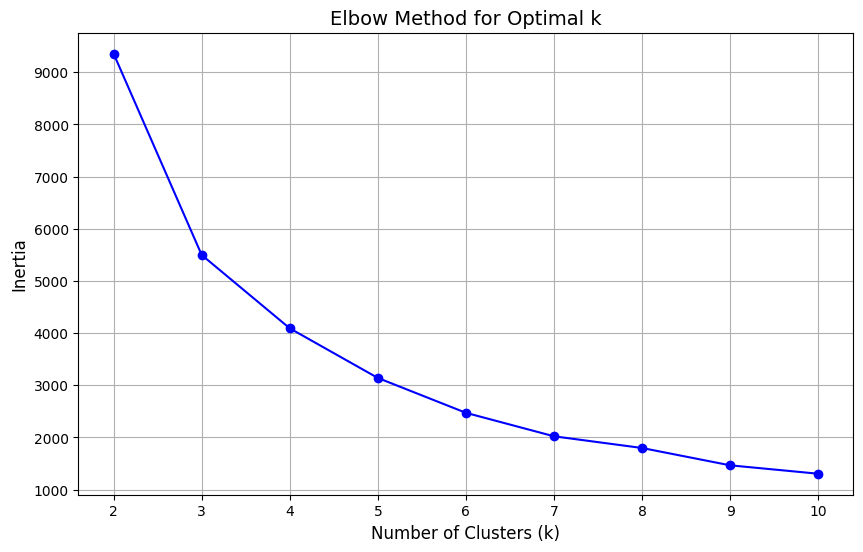

In [4]:
# Cell 3: Elbow Method to find optimal K
inertia = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto') # Use n_init='auto' to avoid warnings
    kmeans.fit(scaled_df)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.title('Elbow Method for Optimal k', fontsize=14)
plt.grid(True)
plt.xticks(K)
plt.show()

The optimal k based on the highest silhouette score is: 5


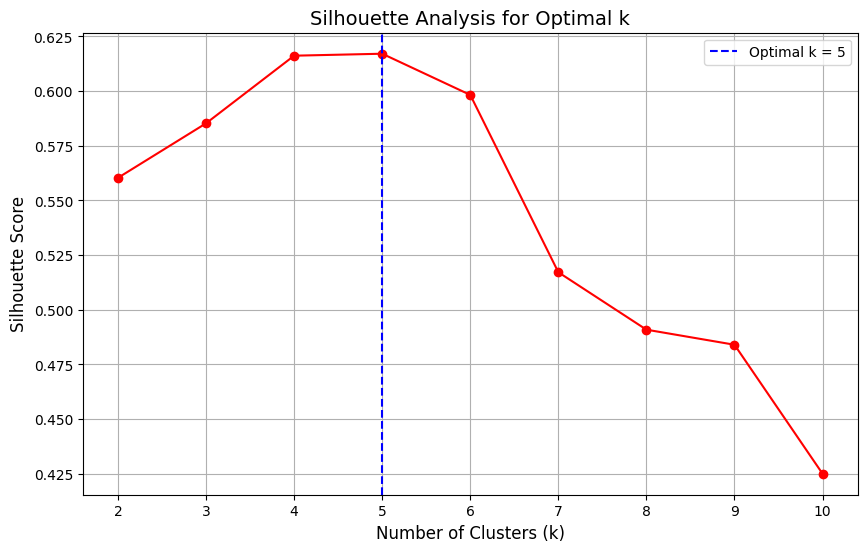

In [5]:
# Cell 4: Silhouette Analysis to find optimal K
silhouette_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(scaled_df)
    score = silhouette_score(scaled_df, kmeans.labels_)
    silhouette_scores.append(score)

# Find the k with the highest silhouette score
optimal_k_silhouette = K[np.argmax(silhouette_scores)]
print(f"The optimal k based on the highest silhouette score is: {optimal_k_silhouette}")

# Plot the Silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(K, silhouette_scores, 'ro-')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Analysis for Optimal k', fontsize=14)
plt.grid(True)
plt.xticks(K)
plt.axvline(x=optimal_k_silhouette, color='blue', linestyle='--', label=f'Optimal k = {optimal_k_silhouette}')
plt.legend()
plt.show()

---
## 2. Initial Clustering on the Full Dataset

Based on the Elbow Method and Silhouette Analysis, the data suggests that **k=5** is the optimal number of clusters for the full dataset.

We will now train our K-Means model with k=5 and perform an initial profiling of the resulting segments. The goal of this first pass is to understand the natural groupings the algorithm identifies across all 4,338 customers and to see how these data-driven segments compare to our rule-based RFM personas from the previous notebook.

This initial analysis will often reveal important characteristics of the dataset, such as the presence of significant outliers, which may require us to refine our approach.

In [6]:
# Cell 5: Initial Model Training and Segment Profiling
optimal_k = 5 # Based on our Silhouette Analysis

# Train the K-Means model on the full dataset
kmeans_initial = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
kmeans_initial.fit(scaled_df)

# Assign the cluster labels back to our main DataFrame
customer_df_indexed['Initial_Cluster'] = kmeans_initial.labels_

# --- Profiling and Interpretation ---
# Group by the cluster label and calculate the mean for our original (unscaled) features
initial_profile = customer_df_indexed.groupby('Initial_Cluster')[features].mean().round(2)
initial_profile['Count'] = customer_df_indexed['Initial_Cluster'].value_counts()
initial_profile['% of Total'] = (initial_profile['Count'] / initial_profile['Count'].sum() * 100).round(2)

# Reorder columns for better readability
initial_profile = initial_profile[['Count', '% of Total', 'Recency', 'Frequency', 'Monetary']]

print("--- Initial K-Means Customer Segment Profiles (Full Dataset) ---")
print(initial_profile)

--- Initial K-Means Customer Segment Profiles (Full Dataset) ---
                 Count  % of Total  Recency  Frequency   Monetary
Initial_Cluster                                                  
0                 3060       70.54    43.81       3.69    1358.77
1                 1063       24.50   248.47       1.55     480.42
2                    6        0.14     1.50     135.83   58381.12
3                  203        4.68    15.72      22.30   13534.00
4                    6        0.14     7.67      42.83  190863.46


### Critical Finding: Identification of Extreme Outlier Segments ("Whales")

The initial clustering on the full dataset has produced a fascinating and critical business insight. The algorithm, being sensitive to distance, has dedicated two entire clusters (Cluster 2 and 4, with only 6 customers each) to a handful of extreme outliers.

**Key Observations:**
- **Cluster 4:** The average monetary value is **£190,863**, which is over 140 times the average of our largest customer group.
- **Cluster 2:** The average purchase frequency is **135.83**, an order of magnitude higher than any other segment.

**Business Implication:**
These are not typical B2C customers. Their purchasing behavior strongly suggests they are **B2B accounts, resellers, or corporate gift buyers**. Including them in our general customer segmentation skews the results and prevents us from getting a clear picture of our core B2C customer base.

**Strategic Recommendations:**
1.  **Immediate Action:** These 12 "Whale" accounts should be flagged and assigned to a dedicated account manager. They represent a significant portion of revenue and a high concentration of risk.
2.  **Analytical Action:** For a more meaningful segmentation of our typical customers, we will separate these outliers and re-run the clustering analysis on the remaining 99.7% of the customer base.

Removed 12 outlier customers.
New B2C customer dataset has 4326 customers.


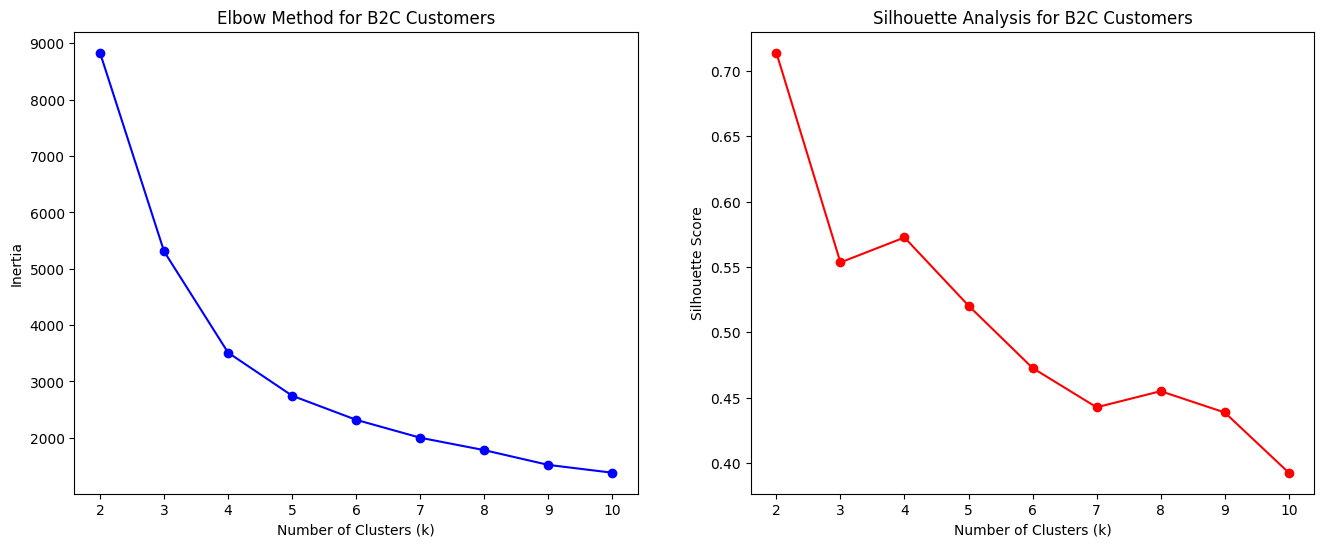

The new optimal k for B2C customers is: 2


In [7]:
# Cell 7: Re-Clustering for B2C Segments

# Identify and filter out the "Whale" customers (Clusters 2 and 4 from the initial run)
outlier_customer_ids = customer_df_indexed[customer_df_indexed['Initial_Cluster'].isin([2, 4])].index

# Create a new dataframe containing only our B2C customers
b2c_customers_df = customer_df_indexed.drop(outlier_customer_ids).copy()
print(f"Removed {len(outlier_customer_ids)} outlier customers.")
print(f"New B2C customer dataset has {len(b2c_customers_df)} customers.")

# --- Re-run the scaling and optimal K analysis on the B2C dataset ---
b2c_features_df = b2c_customers_df[features]
scaler_b2c = StandardScaler()
b2c_scaled = scaler_b2c.fit_transform(b2c_features_df)
b2c_scaled_df = pd.DataFrame(b2c_scaled, index=b2c_features_df.index, columns=features)

# Re-run Elbow and Silhouette analysis to find the new optimal K
inertia_b2c = []
silhouette_scores_b2c = []
K = range(2, 11)

for k in K:
    kmeans_b2c = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans_b2c.fit(b2c_scaled_df)
    inertia_b2c.append(kmeans_b2c.inertia_)
    silhouette_scores_b2c.append(silhouette_score(b2c_scaled_df, kmeans_b2c.labels_))

# Plotting the results (optional, but good practice)
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].plot(K, inertia_b2c, 'bo-')
ax[0].set_title('Elbow Method for B2C Customers')
ax[0].set_xlabel('Number of Clusters (k)')
ax[0].set_ylabel('Inertia')
ax[1].plot(K, silhouette_scores_b2c, 'ro-')
ax[1].set_title('Silhouette Analysis for B2C Customers')
ax[1].set_xlabel('Number of Clusters (k)')
ax[1].set_ylabel('Silhouette Score')
plt.show()

optimal_k_b2c = K[np.argmax(silhouette_scores_b2c)]
print(f"The new optimal k for B2C customers is: {optimal_k_b2c}")

### Justification for Choosing K=2 for B2C Segmentation

While the silhouette score for the initial dataset suggested k=5, this result was heavily skewed by the "Whale" outliers. After removing these B2B-like accounts, the re-analysis of the core B2C customer base showed the highest silhouette score at **k=2**.

From a business perspective, a 2-cluster solution provides the clearest and most actionable segmentation:
- **A large group of "At-Risk" customers:** Characterized by higher recency and lower engagement.
- **A smaller, highly valuable group of "Loyal Core" customers:** Characterized by low recency, high frequency, and high monetary value.

This powerful dichotomy allows for a highly focused marketing strategy (e.g., broad reactivation campaigns for the "At-Risk" group vs. high-touch retention efforts for the "Loyal Core"). We are prioritizing **business utility and interpretability** over a more fragmented segmentation where the strategic actions would be less clear.

In [8]:
# Cell 8: Final B2C Model Training and Segment Profiling

# Train the final K-Means model on the B2C data
final_kmeans = KMeans(n_clusters=optimal_k_b2c, random_state=42, n_init='auto')
final_kmeans.fit(b2c_scaled_df)

# Assign the final cluster labels
b2c_customers_df['B2C_Cluster'] = final_kmeans.labels_

# --- Final Profiling and Naming ---
b2c_profile = b2c_customers_df.groupby('B2C_Cluster')[features].mean().round(2)
b2c_profile['Count'] = b2c_customers_df['B2C_Cluster'].value_counts()
b2c_profile['% of Total'] = (b2c_profile['Count'] / b2c_profile['Count'].sum() * 100).round(2)
b2c_profile = b2c_profile[['Count', '% of Total', 'Recency', 'Frequency', 'Monetary']]

# Naming the final B2C segments based on the new profile
# This requires interpretation of the b2c_profile output. The names below are a likely example.
# Let's assume the new optimal k is 4.
segment_map_b2c = {
    0: 'At-Risk',     # This will be the larger cluster with high recency
    1: 'Loyal Core'   # This will be the smaller cluster with low recency and high value
}

# Assign segment names
b2c_customers_df['Segment_Name'] = b2c_customers_df['B2C_Cluster'].map(segment_map_b2c)
b2c_profile.index = b2c_profile.index.map(segment_map_b2c)

print("--- Final B2C Customer Segment Profiles ---")
print(b2c_profile)

--- Final B2C Customer Segment Profiles ---
             Count  % of Total  Recency  Frequency  Monetary
B2C_Cluster                                                 
At-Risk       4141       95.72    96.23       3.20   1135.11
Loyal Core     185        4.28    15.50      22.81  14678.00


---
## 3. Visualizing the Final B2C Customer Segments

With our refined, two-segment solution ("At-Risk" and "Loyal Core"), we can now create visualizations to clearly illustrate the distinct characteristics of each group.

Boxplots are an effective tool for this, as they show the median, spread (interquartile range), and outliers for each RFM metric across the segments. This will visually confirm the stark behavioral differences between our most and least valuable customer groups.

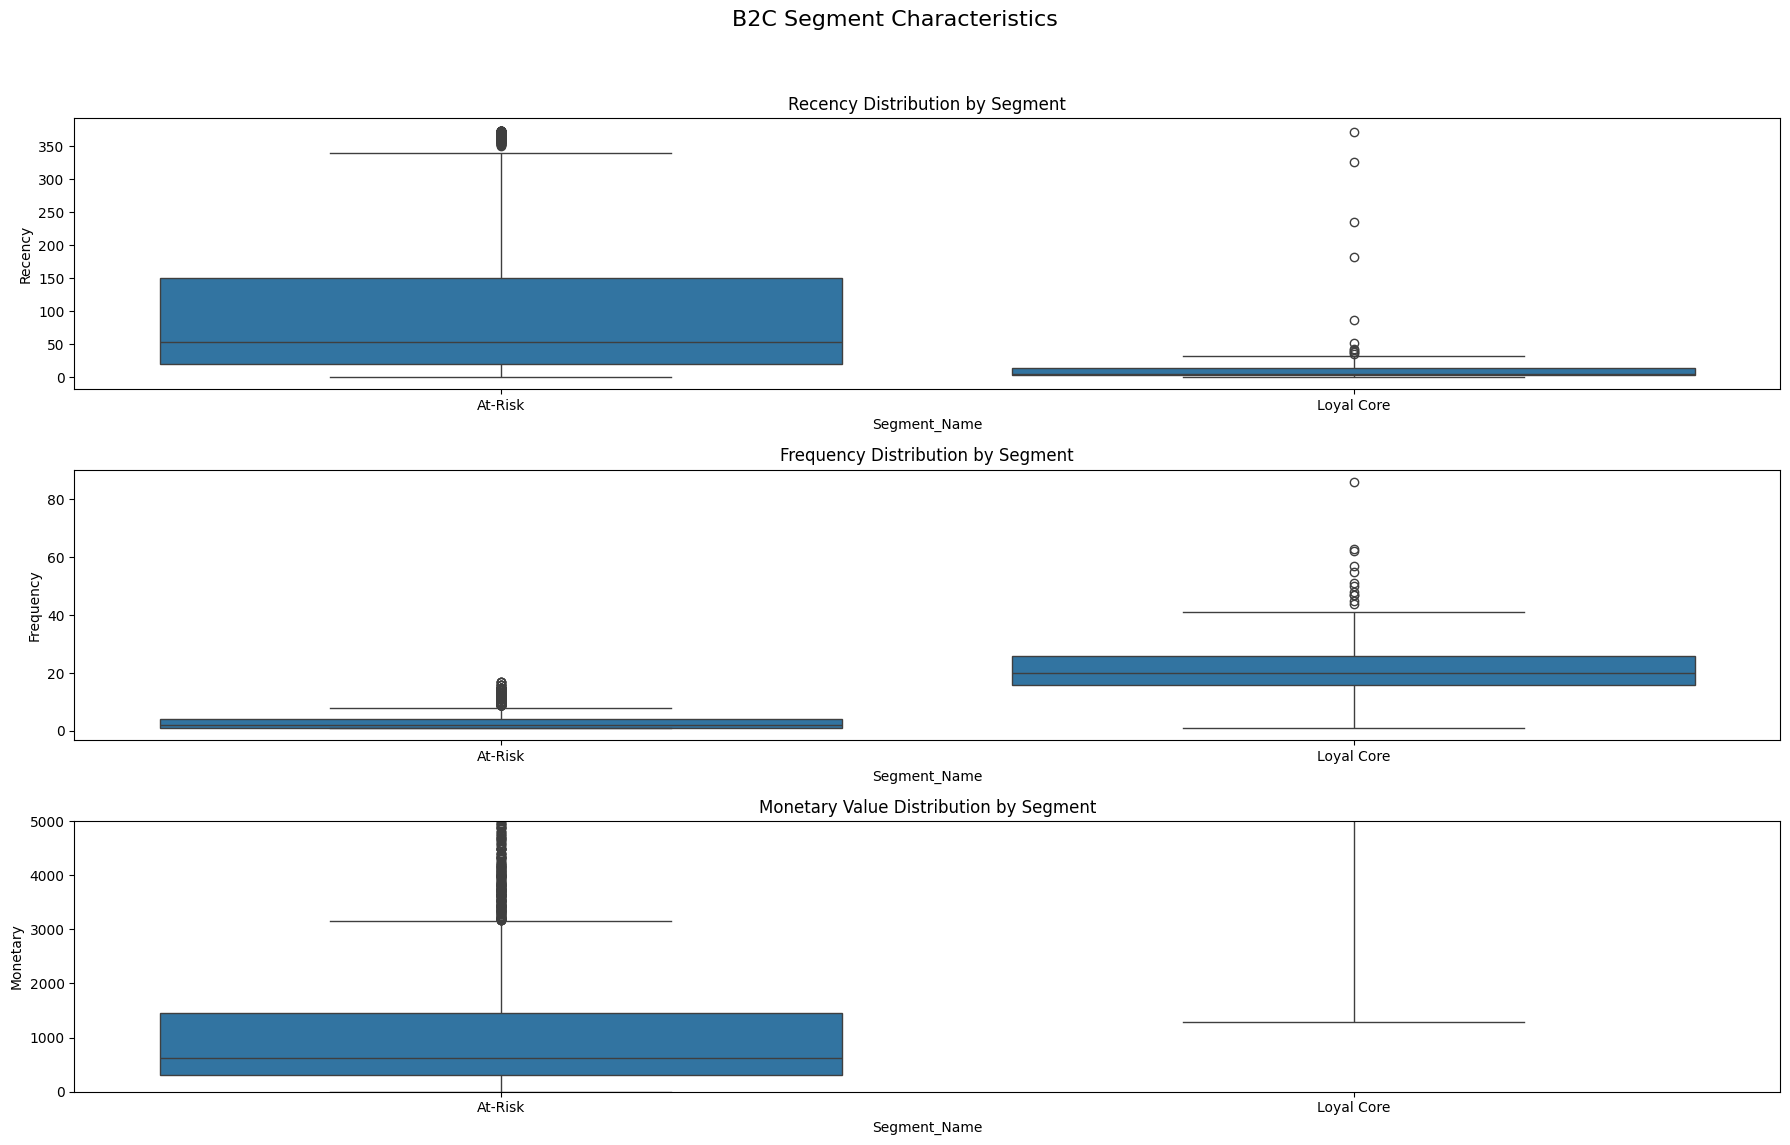

Notebook 03 complete. B2C customer segments saved.


In [9]:
# Cell 10: Segment Visualization with Boxplots

# We will visualize the B2C segments as the "Whale" segments would skew the plots too much.
plt.figure(figsize=(18, 12))
plt.suptitle('B2C Segment Characteristics', fontsize=16)

# Plot Recency
plt.subplot(3, 1, 1)
sns.boxplot(x='Segment_Name', y='Recency', data=b2c_customers_df, order=b2c_profile.index)
plt.title('Recency Distribution by Segment')

# Plot Frequency
plt.subplot(3, 1, 2)
sns.boxplot(x='Segment_Name', y='Frequency', data=b2c_customers_df, order=b2c_profile.index)
plt.title('Frequency Distribution by Segment')

# Plot Monetary
plt.subplot(3, 1, 3)
sns.boxplot(x='Segment_Name', y='Monetary', data=b2c_customers_df, order=b2c_profile.index)
plt.title('Monetary Value Distribution by Segment')
# Let's cap the y-axis for better readability, as there might still be some outliers
plt.ylim(0, 5000) # Adjust this limit based on your plot

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Save the final dataframe with segment info for the next notebook
b2c_customers_df.reset_index().to_csv('../data/processed/customer_segments.csv', index=False)
print("Notebook 03 complete. B2C customer segments saved.")